In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this example we are going to train a CNN for the task of multi-label image classification using the BigEarthNet dataset using both S1 and S2 images as inputs.

## The dataset

The dataset consists of pairs of S1 and S2 images. You can choose which bands to use for each sensor. Image are labeled with 47 different classes, images can have multiple labels. Following the work of the original authors of the dataset, you can group the labels to produce a smaller set of classes.

In [75]:
from pytorch_eo.datasets.big_earth_net import BigEarthNet
from pytorch_eo.datasets.big_earth_net.utils import LABELS19
from pytorch_eo.utils.sensors import Sensors, S1, S2

ds = BigEarthNet(
    batch_size=5, 
	bands={  # choose bands to use for each sensor
        Sensors.S1: [S1.VH, S1.VV],         
        # Sensors.S2: [S2.red, S2.green, S2.blue]
        Sensors.S2: [S2.red, S2.green, S2.blue, S2.nir1]
    }, 
    label_groups=LABELS19, # chose label group (remove to use all the original labels)
    verbose=True
)

ds.setup()

Loading ... processed_S1_S2_LABELS19.json
training samples 354196
validation samples 118065
test samples 118065


In [76]:
ds.df

,s1_images,s2_images,labels,encoded_labels
0,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Land principally occupied by agr...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
2,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Pastures]","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Permanent crops, Moors, heathland and sclerop...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
590321,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,"[Arable land, Pastures, Land principally occup...","[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, ..."
590322,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Arable land, Pastures, Agro-forestry areas]","[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
590323,data/BigEarthNet/BigEarthNet-S1-v1.0/S1B_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2A_MSIL2A_2...,"[Urban fabric, Industrial or commercial units,...","[1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
590324,data/BigEarthNet/BigEarthNet-S1-v1.0/S1A_IW_GR...,data/BigEarthNet/BigEarthNet-v1.0/S2B_MSIL2A_2...,[Marine waters],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [77]:
ds.num_classes, ds.classes

(19,
 ['Urban fabric',
  'Industrial or commercial units',
  'Arable land',
  'Permanent crops',
  'Pastures',
  'Complex cultivation patterns',
  'Land principally occupied by agriculture, with significant areas of natural vegetation',
  'Agro-forestry areas',
  'Broad-leaved forest',
  'Coniferous forest',
  'Mixed forest',
  'Natural grassland and sparsely vegetated areas',
  'Moors, heathland and sclerophyllous vegetation',
  'Transitional woodland, shrub',
  'Beaches, dunes, sands',
  'Inland wetlands',
  'Coastal wetlands',
  'Inland waters',
  'Marine waters'])

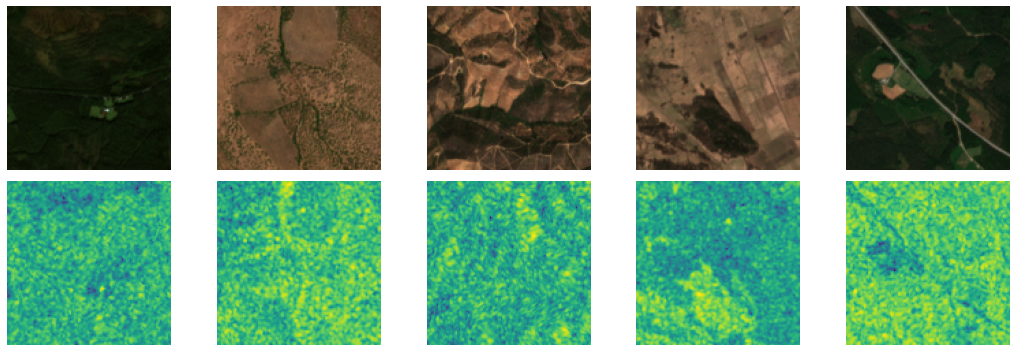

In [78]:
import matplotlib.pyplot as plt
from pytorch_eo.utils.image import to_uint8

batch = next(iter(ds.train_dataloader()))
s1_imgs, s2_imgs, labels = batch['S1'], batch['S2'], batch['labels']

fig = plt.figure(figsize=(3*len(labels), 5))
th = 3000
for i, (s1, s2, label) in enumerate(zip(s1_imgs, s2_imgs, labels)):
	ax = plt.subplot(2, len(labels), i + 1)
	img = to_uint8(s2, 0, th)
	ax.imshow(img[...,:3])
	ax.axis('off')
	ax = plt.subplot(2, len(labels), i + 1 + len(labels))
	ax.imshow(s1[...,0])
	ax.axis('off')
plt.tight_layout()
plt.show()

Data augmentation in data fusion applications must be done carefully, since all the images must be augmented in the same way. 

In [79]:
import albumentations as A

trans = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate()
], additional_targets={'S1': 'image', 'S2': 'image'})

ds = BigEarthNet(
    path="./data/BigEarthNet", 
    batch_size=5, 
	bands={  # choose bands to use for each sensor
        Sensors.S1: [S1.VH, S1.VV],         
        Sensors.S2: [S2.red, S2.green, S2.blue]
    }, 
    label_groups=LABELS19, # chose label group (remove to use all the original labels)
    verbose=True,
    train_trans=trans
)

ds.setup()

Loading ... processed_S1_S2_LABELS19.json
training samples 354196
validation samples 118065
test samples 118065


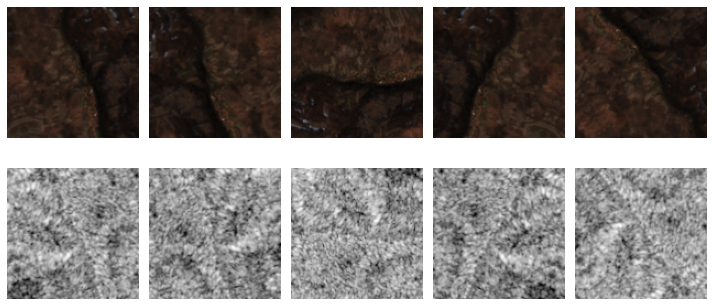

In [80]:
import random 

fig = plt.figure(figsize=(10, 5))
th = 4000
rounds = 5
ix = random.randint(0, len(ds.train_ds)-1)
for i, img in enumerate(range(rounds)):
    ax = plt.subplot(2, rounds, i + 1)
    sample = ds.train_ds[ix] 
    s1_img, s2_img, labels = sample['S1'], sample['S2'], sample['labels']
    s2_img = to_uint8(s2_img, 0, th)
    ax.imshow(s2_img[...,:3])
    ax.axis('off')
    ax = plt.subplot(2, rounds, i + 1 + rounds)
    ax.imshow(s1_img[...,0], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

## The Model

Our model will use a `Resnet18` as a feature extractor. We will use one for each image source. The final features will be concatenated and passed to a linear classifier.

In [81]:
from einops import rearrange
import torch
import timm 

def create_backbone(backbone, in_chans, pretrained=None):
    return timm.create_model(
        backbone,
        pretrained=pretrained,
        in_chans=in_chans,
        features_only=True
    )

class Model(torch.nn.Module):

    def __init__(self, num_classes, s1_chans=2, s2_chans=4, backbone='resnet18', max_value=4000):
        super().__init__()
        self.s1_backbone = create_backbone(backbone, s1_chans)
        self.s2_backbone = create_backbone(backbone, s2_chans)
        self.head = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(self.s1_backbone.feature_info.channels(-1) + self.s2_backbone.feature_info.channels(-1), num_classes)
        )
        self.max_value = max_value

    def forward(self, x):
        # get images
        x1, x2 = x # the order is the same as 'inputs' in task
        # channels first
        x1 = rearrange(x1, 'b h w c -> b c h w')
        x2 = rearrange(x2, 'b h w c -> b c h w')
        # undo db (s1) and normalize (s2)
        x1 = 10**(x1 / 10)
        x1 = x1.clip(0, 1)
        x2 = x2 / self.max_value
        x2 = x2.clip(0, 1)
        # extract features
        z1 = self.s1_backbone(x1)[-1]
        z2 = self.s2_backbone(x2)[-1]
        # classification
        z = torch.cat([z1, z2], axis=1)
        return self.head(z)

In [82]:
model = Model(num_classes=ds.num_classes)

out = model((s1_imgs, s2_imgs))

out.shape

torch.Size([5, 19])

## Training

In [83]:
import pytorch_lightning as pl
from sklearn.metrics import average_precision_score
from pytorch_eo.tasks.classification import ImageMultilabelClassification

# pl.seed_everything(42, workers=True)

def my_map(y_hat, y):
    return average_precision_score(y.cpu(), torch.sigmoid(y_hat).detach().cpu(), average='micro')

ds = BigEarthNet(
	bands={  # choose bands to use for each sensor
        Sensors.S1: [S1.VH, S1.VV],         
        Sensors.S2: [S2.red, S2.green, S2.blue, S2.nir1]
    }, 
    label_groups=LABELS19,
)

hparams = {
    'optimizer': 'Adam',
    'optim_params': {
        'lr': 1e-4,
    },
    # 'scheduler': 'MultiStepLR',
    # 'scheduler_params': {
    #     'milestones': [int(0.6*max_epochs), int(0.8*max_epochs)]
    # },
}

metrics = {'map': my_map} 

model = Model(num_classes=ds.num_classes)

task = ImageMultilabelClassification(model, hparams=hparams, metrics=metrics, inputs=['S1', 'S2']) # same order given in ' forward'

In [84]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

# callbacks=[
#     ModelCheckpoint(
#         dirpath='./',
#         filename=f'BigEarthNet-{{val_map:.3f}}',
#         save_top_k=1,
#         monitor='val_map',
#         mode='max'
#     ),
#     LearningRateMonitor(logging_interval='step')
# ]

trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
    # callbacks=callbacks,
    # deterministic=True,
    limit_train_batches=30,
    limit_val_batches=10
)

trainer.fit(task, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Loading ... processed_S1_S2_LABELS19.json


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | Model             | 22.4 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.490    Total estimated model params size (MB)


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
